In [1]:
import os
import re
import glob
import yaml

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

from math import ceil

import tifffile

import zarr
import napari
import dask.array as da

from utils.utility_functions import single_channel_pyramid

In [2]:
out = os.path.join(os.getcwd(), 'output/VAE20-33_VAE9_ROT_VIG18_percentages')
if not os.path.exists(out):
    os.makedirs(out)

sample = 'CRC-097'

tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/hema_eosin.ome.tif')

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# Get list of markers that were excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# Import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# Get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

# Import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# The parquet file at the path below is being read because "main.csv" 
# uses trimmed marker channel names as column headers that differ from the raw channel names used 
# in the markers.csv file used to index channels in the OME-TIFF image.
for_channels = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# isolate antibodies of interest
abx_channels = [
    i for i in for_channels.columns if 'nucleiRingMask' in i if 'Hoechst' not in i
    if i not in markers_to_exclude
]

In [3]:
# Isolate cluster V20-3
vae33 = main[main['VAE20_Leiden'] == 33]

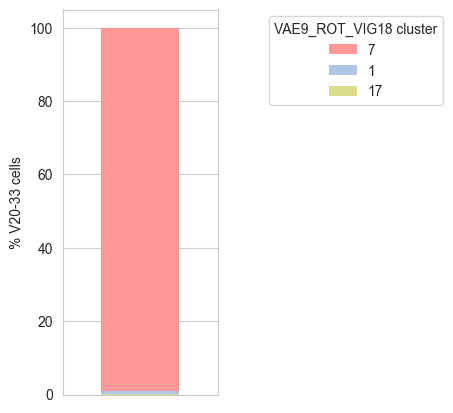

VAE9_ROT_VIG18
7     99.156118
1      0.703235
17     0.140647
dtype: float64


In [4]:
# Plot stacked barchart
plot_input = (vae33.groupby('VAE9_ROT_VIG18').size() / len(vae33) * 100).sort_values(ascending=True)

plt.rcParams['font.family'] = 'Arial'
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(2, 5))

# num_colors = len(list(cm.tab10.colors))
# num_clusters = len(plot_input.index.unique())
# palette_multiplier = ceil(num_clusters / num_colors)
# colors = list(cm.tab10.colors) * palette_multiplier
# colors = colors[0:num_clusters]
# colors.reverse()

colors = [
    (0.85882353, 0.85882353, 0.55294118),
    (0.68235294, 0.78039216, 0.90980392),
    (1.0, 0.59607843, 0.58823529),
]

pd.DataFrame(plot_input).T.plot.bar(stacked=True, ax=ax, lw=0.0, color=colors)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1], title='VAE9_ROT_VIG18 cluster',
    loc='upper right', bbox_to_anchor=(2.5, 1)
)
plt.ylabel('% V20-33 cells')
ax.set(xticklabels=[])
ax.xaxis.grid(False)

plt.savefig(os.path.join(out, 'V20-33_VAE9_ROT_VIG18_percentages.pdf'), bbox_inches='tight')
plt.show()
plt.close('all')

print(plot_input.sort_values(ascending=False))

In [5]:
# Add H&E image to Napari viewer as separate RGB channels
# for color, channel in zip(['red', 'green', 'blue'], [0, 1, 2]):

#     img, min, max = single_channel_pyramid(glob.glob(he_path)[0], channel=channel)

#     if channel == 0:
#         viewer = napari.view_image(
#             img, rgb=False, colormap=color, blending='additive',
#             visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
#         )
#     else:
#         viewer.add_image(
#             img, rgb=False, colormap=color, blending='additive',
#             visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
#         )

# add H&E image to Napari viewer as a single channel image
# from lazy_ops import DatasetView
# tiff = tifffile.TiffFile(he_path, is_ome=False)
# pyramid = [
#     zarr.open(tiff.series[0].levels[0].aszarr())[i] for i in
#     list(range(len(tiff.series[0].levels)))
#     ]
# pyramid = [DatasetView(i).lazy_transpose([1, 2, 0]) for i in pyramid]
# pyramid = [da.from_zarr(z) for z in pyramid]
#
# viewer = napari.view_image(pyramid, rgb=True, name='H&E')

In [6]:
# Add DNA1 channel to Napari image viewer
# dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
# viewer.add_image(
#     dna, rgb=False, blending='additive', colormap='gray', visible=True,
#     opacity=0.75, name='DNA1', contrast_limits=(min, max)
# )

In [7]:
# Add marker channels and apply previously defined contrast limits
# for ch in abx_channels:
#     ch = ch.rsplit('_', 1)[0]
#     channel_number = markers['channel_number'][markers['marker_name'] == ch]
#     img, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
#     )
#     viewer.add_image(
#         img, rgb=False, blending='additive', colormap='green', visible=False, name=ch,
#         contrast_limits=(min, max)
#     )
# for ch in abx_channels:
#     ch = ch.rsplit('_', 1)[0]
#     viewer.layers[ch].contrast_limits = (
#         contrast_limits[ch][0], contrast_limits[ch][1])

In [8]:
# Add centroids of cells for VAE9_ROT_VIG18 clusters
# num_colors = len(list(cm.tab10.colors))
# num_clusters = len(main['VAE9_ROT_VIG18'].unique())
# palette_multiplier = ceil(num_clusters / num_colors)
# colors = list(cm.tab10.colors) * palette_multiplier
# colors = colors[0:num_clusters]
# colors.reverse()

# for c, cluster in zip(
#         colors, vae33.groupby('VAE9_ROT_VIG18').size().sort_values().index):
#     centroids = vae33[['Y_centroid', 'X_centroid']][vae33['VAE9_ROT_VIG18'] == cluster]
#     if cluster == 7:
        # face_color = np.array([1.0, 0.59607843, 0.58823529])
#         visible=True
#     else:
#         visible=False
#     viewer.add_points(
#         centroids, name=f'VAE9_ROT_VIG18_{cluster}', face_color=np.array([1.0, 1.0, 1.0]), edge_color='white',
#         edge_width=0.0, size=80.0, opacity=1.0, blending='translucent', visible=visible
#     )

In [9]:
# Read segmentation outlines
# seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
# viewer.add_image(
#     seg, rgb=False, blending='additive', colormap='gray', visible=False,
#     name='segmentation', opacity=0.3, contrast_limits=(min, max)
# )

In [10]:
# Run Napari image viewer
# viewer.scale_bar.visible = True
# viewer.scale_bar.unit = 'um'

# napari.run()

In [11]:
# Isolate cluster V20-3
vae7 = main[main['VAE20_Leiden'] == 7]

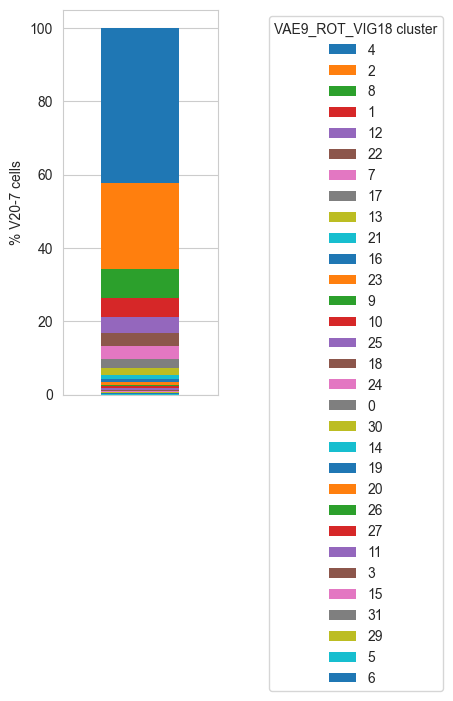

VAE9_ROT_VIG18
4     42.191037
2     23.698506
8      7.808963
1      5.192395
12     4.196469
22     3.725668
7      3.386148
17     2.544138
13     1.874151
21     1.222273
16     0.810321
23     0.710729
9      0.448167
10     0.443640
25     0.425532
18     0.425532
24     0.176550
0      0.153916
30     0.122227
14     0.090539
19     0.081485
20     0.054323
26     0.049796
27     0.045269
11     0.031689
3      0.027162
15     0.022635
31     0.018108
29     0.013581
5      0.004527
6      0.004527
dtype: float64


In [12]:
# Plot stacked barchart
plot_input = (vae7.groupby('VAE9_ROT_VIG18').size() / len(vae7) * 100).sort_values(ascending=True)

plt.rcParams['font.family'] = 'Arial'
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(2, 5))

num_colors = len(list(cm.tab10.colors))
num_clusters = len(plot_input.index.unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab10.colors) * palette_multiplier
colors = colors[0:num_clusters]
colors.reverse()

# colors = [
#     (0.85882353, 0.85882353, 0.55294118),
#     (0.68235294, 0.78039216, 0.90980392),
#     (1.0, 0.59607843, 0.58823529),
# ]

pd.DataFrame(plot_input).T.plot.bar(stacked=True, ax=ax, lw=0.0, color=colors)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1], title='VAE9_ROT_VIG18 cluster',
    loc='upper right', bbox_to_anchor=(2.5, 1)
)
plt.ylabel('% V20-7 cells')
ax.set(xticklabels=[])
ax.xaxis.grid(False)

plt.savefig(os.path.join(out, 'V20-7_VAE9_ROT_VIG18_percentages.pdf'), bbox_inches='tight')
plt.show()
plt.close('all')

print(plot_input.sort_values(ascending=False))

In [13]:
# Add H&E image to Napari viewer as separate RGB channels
for color, channel in zip(['red', 'green', 'blue'], [0, 1, 2]):

    img, min, max = single_channel_pyramid(glob.glob(he_path)[0], channel=channel)

    if channel == 0:
        viewer = napari.view_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
        )
    else:
        viewer.add_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
        )

# add H&E image to Napari viewer as a single channel image
# from lazy_ops import DatasetView
# tiff = tifffile.TiffFile(he_path, is_ome=False)
# pyramid = [
#     zarr.open(tiff.series[0].levels[0].aszarr())[i] for i in
#     list(range(len(tiff.series[0].levels)))
#     ]
# pyramid = [DatasetView(i).lazy_transpose([1, 2, 0]) for i in pyramid]
# pyramid = [da.from_zarr(z) for z in pyramid]
#
# viewer = napari.view_image(pyramid, rgb=True, name='H&E')

In [14]:
# Add DNA1 channel to Napari image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True,
    opacity=0.75, name='DNA1', contrast_limits=(min, max)
)

<Image layer 'DNA1' at 0x14155c5e0>

In [15]:
# Add marker channels and apply previously defined contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False, name=ch,
        contrast_limits=(min, max)
    )
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [16]:
# Add centroids of cells for VAE9_ROT_VIG18 clusters
num_colors = len(list(cm.tab10.colors))
num_clusters = len(main['VAE9_ROT_VIG18'].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab10.colors) * palette_multiplier
colors = colors[0:num_clusters]
colors.reverse()

for c, cluster in zip(
        colors, vae7.groupby('VAE9_ROT_VIG18').size().sort_values().index):
    centroids = vae7[['Y_centroid', 'X_centroid']][vae7['VAE9_ROT_VIG18'] == cluster]
    arrow, clobber, cross, diamond, disc, hbar, ring, square, star, tailed_arrow, triangle_down, triangle_up, vbar, x
    if cluster == 4:
        symbol = 'cross'
        visible=True
    elif cluster == 2:
        symbol = 'hbar'
        visible=True
    elif cluster == 8:
        symbol = 'triangle_up'
        visible=True
    elif cluster == 1:
        symbol = 'square'
        visible=True
    elif cluster == 12:
        symbol = 'star'
        visible=True
    elif cyluster == 22:
        symbol = 'ring'
        visible=True
    elif cluster == 7:
        symbol = 'disc'
        visible=True
    else:
        symbol = 'disc'
        visible=False
    viewer.add_points(
        centroids, name=f'VAE9_ROT_VIG18_{cluster}', face_color=face_color, edge_color='white',
        edge_width=0.0, size=80.0, opacity=1.0, blending='translucent', visible=visible,
        symbol=symbol
    )

In [17]:
# Read segmentation outlines
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3, contrast_limits=(min, max)
)

<Image layer 'segmentation' at 0x15dd0f1f0>

In [18]:
# Run Napari image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()